## Tensorflow 基础知识

Eager Execution
无需构建计算图，计算直接返回具体的值

In [48]:
import os  
import tensorflow as tf 
import cProfile

In [49]:
tf.executing_eagerly()

True

In [50]:
x = [[2.0]]
m = tf.matmul(x,x)
print("hello,{}".format(m))

hello,[[4.]]


TensorFlow tf.math 运算会将 Python 对象和 NumPy 数组转换为 tf.Tensor 对象。

In [51]:
a = tf.constant([[1,2], 
                 [3,4]])
print(a)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


In [52]:
b = tf.add(a,1)
b

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[2, 3],
       [4, 5]], dtype=int32)>

In [53]:
print(a*b)

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [54]:
import numpy as np
c = np.multiply(a,b)
c 

array([[ 2,  6],
       [12, 20]], dtype=int32)

In [55]:
print(a.numpy())
# 这里就不是张量了，而是普通矩阵

[[1 2]
 [3 4]]


In [56]:
def fizzbuzz(max_num):
  counter = tf.constant(0)
  max_num = tf.convert_to_tensor(max_num)
  for num in range(1, max_num.numpy()+1):
    num = tf.constant(num)
    if int(num % 3) == 0 and int(num % 5) == 0:
      print('FizzBuzz')
    elif int(num % 3) == 0:
      print('Fizz')
    elif int(num % 5) == 0:
      print('Buzz')
    else:
      print(num.numpy())
    counter += 1

In [57]:
fizzbuzz(15)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


## Eager 训练
可以在 Eager Execution 中使用 tf.GradientTape 来训练和/或计算梯度

In [58]:

w = tf.Variable([[1.0]])  # 定义一个可训练变量 w，其初值为 1.0
with tf.GradientTape() as tape:  # 开启梯度记录环境
    loss = w * w  # 定义损失函数 loss = w^2
    grad = tape.gradient(loss, w)  # 计算 loss 对 w 的梯度
print(grad)  # 打印梯度值

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


In [59]:
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()
dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast(mnist_images[..., tf.newaxis]/255, tf.float32),
     tf.cast(mnist_labels, tf.int64))
)
dataset = dataset.shuffle(1000).batch(32)

In [60]:
mnist_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, [3,3], activation='relu',
                           input_shape=(None, None, 1)), 
    tf.keras.layers.Conv2D(16,[3,3],activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10)
])

d:\Python\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


即使没有训练，也可以在 Eager Execution 中调用模型并检查输出：

In [61]:
for image, labels in dataset.take(1):
    print("logits:", mnist_model(image[0:1]).numpy)

logits: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.00174823, -0.02383006, -0.02771685, -0.01847021, -0.0254468 ,
         0.01042473,  0.0055995 , -0.02450933,  0.01169565, -0.00391844]],
      dtype=float32)>>


虽然 Keras 模型有内置训练循环（使用 fit 方法），但有时您需要进行更多自定义。下面是一个使用 Eager Execution 实现训练循环的示例：

In [62]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_history = []



In [73]:
# 定义单次训练步骤的函数
def train_step(images, labels):
    # 使用 tf.GradientTape 记录梯度计算过程
    with tf.GradientTape() as tape:
        # 前向传播：通过模型获取预测值 (logits)
        logits = mnist_model(images, training=True)  # 设置模型为训练模式

        # 检查 logits 的输出形状是否正确，确保为 (32, 10)
        tf.debugging.assert_equal(logits.shape, (32, 10))
        
        # 计算损失值，比较预测结果与真实标签
        loss_value = loss_object(labels, logits)
    
    # 将当前损失值（取均值）转换为 NumPy 数值并保存到损失历史中
    loss_history.append(loss_value.numpy().mean())
    
    # 计算损失对模型所有可训练变量的梯度
    grads = tape.gradient(loss_value, mnist_model.trainable_variables)
    
    # 使用优化器更新模型权重，将梯度应用到对应变量
    optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [74]:
# 定义完整训练过程的函数
def train(epochs):
    """
    epochs: 训练的总轮数
    """
    # 遍历每个训练轮次
    for epoch in range(epochs):
        # 遍历数据集的每个批次
        for (batch, (images, labels)) in enumerate(dataset):
            # 对当前批次执行一次训练步骤
            train_step(images, labels)
        
        # 打印当前训练轮次完成的信息
        print(f'Epoch {epoch} finished')

In [75]:
train(epochs = 3)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished


Text(0, 0.5, 'Loss [entropy]')

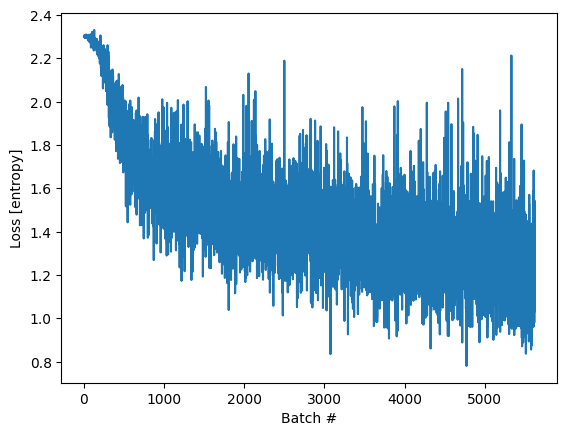

In [71]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

In [85]:
class Linear (tf.keras.Model):
    def __init__(self):
        super(Linear, self).__init__()
        self.W = tf.Variable(5., name='weight')
        self.B = tf.Variable(10., name='bias')
    def call(self, inputs):
        return inputs * self.W + self.B

In [88]:
NUM_EXAMPLES = 2000
training_inputs = tf.random.normal([NUM_EXAMPLES])
noise = tf.random.normal([NUM_EXAMPLES])
training_outputs = training_inputs*3 + 2 + noise

# The loss function to be optimized
def loss(model, inputs, targets):
    error = model(inputs) - targets
    return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, [model.W, model.B]) 

In [89]:
model = Linear()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
print("Initial loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

steps = 300
for i in range(steps):
    grads = grad(model, training_inputs, training_outputs)
    optimizer.apply_gradients(zip(grads, [model.W, model.B]))
    if i % 20 ==0:
        print("Loss at step {:.3f}".format(i, loss(model,training_inputs, training_outputs)))

Initial loss: 68.916
Loss at step 0.000
Loss at step 20.000
Loss at step 40.000
Loss at step 60.000
Loss at step 80.000
Loss at step 100.000
Loss at step 120.000
Loss at step 140.000
Loss at step 160.000
Loss at step 180.000
Loss at step 200.000
Loss at step 220.000
Loss at step 240.000
Loss at step 260.000
Loss at step 280.000


In [91]:
print("W = {}, B ={}".format(model.W.numpy(), model.B.numpy()))

W = 3.013031005859375, B =1.99964439868927


保存模型权重
tf.keras.model

In [95]:
model.save_weights('model_test.weights.h5')
status = model.load_weights('model_test.weights.h5')

In [96]:
# 您可以使用 tf.train.Checkpoint 完全控制此过程。
x = tf.Variable(10.)
checkpoint = tf.train.Checkpoint(x=x)


In [97]:
x.assign(2.) # Assign a new value to the variables and save.
checkpoint_path = './ckpt'
checkpoint.save('./ckpt/')

'./ckpt/-1'

In [98]:
x.assign(11.)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))
print(x)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>


In [100]:
from tensorflow.keras.layers import Conv2D, Dense, GlobalAveragePooling2D, Dense
from tensorflow.keras import Sequential

In [103]:
model = Sequential([
    Conv2D(16, [3,3], activation='relu'), 
    GlobalAveragePooling2D(),
    Dense(10)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
checkpoint_dir = 'path/to/model_dir'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
root = tf.train.Checkpoint(optimizer=optimizer, model=model)
root.save(checkpoint_prefix)
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

## 面向对象的指标
tf.keras.metrics 会被存储为对象。可以通过将新数据传递给可调用对象来更新指标，并使用 tf.keras.metrics.result 方法检索结果，例如：

In [107]:
m = tf.keras.metrics.Mean("loss")
m(0)
m(5)
m.result()
m([8,9])
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=5.5>

## TensorBoard
 一种可视化工具，用于了解、调试和优化模型训练过程。它使用在执行程序时编写的摘要事件。

您可以在 Eager Execution 中使用 tf.summary 记录变量摘要。例如，要每 100 个训练步骤记录一次 loss 的摘要，请运行以下代码：

In [109]:
logdir = "./tb/"
writer = tf.summary.create_file_writer(logdir)

steps = 1000
with writer.as_default():
    for i in range(steps):
        step = i +1
        loss = 1-0.001*step
        if step % 100 ==0:
            tf.summary.scalar('loss', loss, step=step)

In [ ]:
ls tb/

## 自动微分高级主题

tf.GradientTape 也可以用于动态模型。下面这个回溯线搜索算法示例看起来就像普通的 NumPy 代码，但它的控制流比较复杂，存在梯度且可微分

In [113]:
def line_search_step(fn, init_x, rate=1.0):
    with tf.GradientTape() as tape:
        tape.watch(init_x)
        value = fn(init_x)
    grad = tape.gradient(value, init_x)
    grad_norm = tf.reduce_sum(grad*grad)
    init_value = value()
    while value > init_value - rate*grad_norm:
        x = init_x -rate * grad
        value = fn(x)
        rate /=2.0
        return x, value

## 自定义梯度
自定义梯度是重写梯度的一种简单方法。在前向函数中，定义相对于输入、输出或中间结果的梯度。例如，下面是在后向传递中裁剪梯度范数的一种简单方法


In [115]:
@tf.custom_gradient
def clip_gradinet_by_norm(x, norm):
    y = tf.identity(x)
    def grad_fn(dresult):
        return [tf.clip_by_norm(dresult, norm), None]
    return y ,grad_fn

自定义梯度通常用来为运算序列提供数值稳定的梯度：

In [118]:
def log1pexp(x):
    return tf.math.log(1 + tf.exp(x))

def grad_log1pexp(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        value = log1pexp(x)
    return tape.gradient(value, x)

In [119]:
# The gradient computation works fine at x = 0.
grad_log1pexp(tf.constant(0.)).numpy()

np.float32(0.5)

In [120]:
# However, x = 100 fails because of numerical instability.
grad_log1pexp(tf.constant(100.)).numpy()

np.float32(nan)

In [121]:
@tf.custom_gradient
def log1pexp(x):
  e = tf.exp(x)
  def grad(dy):
    return dy * (1 - 1 / (1 + e))
  return tf.math.log(1 + e), grad

def grad_log1pexp(x):
  with tf.GradientTape() as tape:
    tape.watch(x)
    value = log1pexp(x)
  return tape.gradient(value, x)

In [122]:
# As before, the gradient computation works fine at x = 0.
grad_log1pexp(tf.constant(0.)).numpy()

np.float32(0.5)

In [123]:
# And the gradient computation also works at x = 100.
grad_log1pexp(tf.constant(100.)).numpy()

np.float32(1.0)

In [124]:
import time

def measure(x, steps):
  # TensorFlow initializes a GPU the first time it's used, exclude from timing.
  tf.matmul(x, x)
  start = time.time()
  for i in range(steps):
    x = tf.matmul(x, x)
  # tf.matmul can return before completing the matrix multiplication
  # (e.g., can return after enqueing the operation on a CUDA stream).
  # The x.numpy() call below will ensure that all enqueued operations
  # have completed (and will also copy the result to host memory,
  # so we're including a little more than just the matmul operation
  # time).
  _ = x.numpy()
  end = time.time()
  return end - start

shape = (1000, 1000)
steps = 200
print("Time to multiply a {} matrix by itself {} times:".format(shape, steps))

# Run on CPU:
with tf.device("/cpu:0"):
  print("CPU: {} secs".format(measure(tf.random.normal(shape), steps)))

# Run on GPU, if available:
if tf.config.experimental.list_physical_devices("GPU"):
  with tf.device("/gpu:0"):
    print("GPU: {} secs".format(measure(tf.random.normal(shape), steps)))
else:
  print("GPU: not found")

Time to multiply a (1000, 1000) matrix by itself 200 times:
CPU: 2.471346616744995 secs
GPU: not found


In [125]:
if tf.config.experimental.list_physical_devices("GPU"):
  x = tf.random.normal([10, 10])

  x_gpu0 = x.gpu()
  x_cpu = x.cpu()

  _ = tf.matmul(x_cpu, x_cpu)    # Runs on CPU
  _ = tf.matmul(x_gpu0, x_gpu0)  # Runs on GPU:0